## Global warming is a hot topic these days. Debate over global warming has been going all around the world.  Temperature visualization is one of the most important arguments in conversations so it's time to plot some data

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# using Basemap for map visualization. Installed it with "conda install basemap"
from mpl_toolkits.basemap import Basemap
from matplotlib import animation, rc
from IPython.display import HTML

import warnings
warnings.filterwarnings('ignore')

In [2]:
globaltemp = pd.read_csv('../input/GlobalTemperatures.csv', parse_dates=['dt'])
globaltemp.head(3)

dt  LandAverageTemperature  LandAverageTemperatureUncertainty  \
0 1750-01-01                   3.034                              3.574   
1 1750-02-01                   3.083                              3.702   
2 1750-03-01                   5.626                              3.076   

   LandMaxTemperature  LandMaxTemperatureUncertainty  LandMinTemperature  \
0                 NaN                            NaN                 NaN   
1                 NaN                            NaN                 NaN   
2                 NaN                            NaN                 NaN   

   LandMinTemperatureUncertainty  LandAndOceanAverageTemperature  \
0                            NaN                             NaN   
1                            NaN                             NaN   
2                            NaN                             NaN   

   LandAndOceanAverageTemperatureUncertainty  
0                                        NaN  
1                                        NaN  
2                                        NaN

## Let's look how average temperature changes over the years:

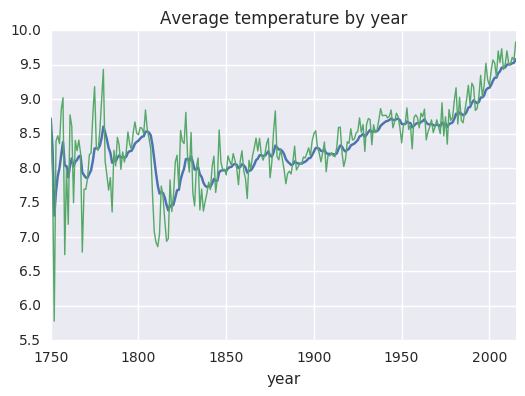

In [3]:
year_temp = globaltemp.groupby(globaltemp.dt.dt.year).mean()
pd.stats.moments.ewma(year_temp.LandAverageTemperature, 5).plot()
year_temp.LandAverageTemperature.plot(linewidth=1)
plt.title('Average temperature by year')
plt.xlabel('year')

## There is clearly an upward trend in the Earth's temperature over the last 150 years. But what if this increase is caused by warming only in underpopulated places like Antarctica or Siberia? Let's examine such graphs for some cities!

In [4]:
bycities = pd.read_csv('../input/GlobalLandTemperaturesByCity.csv', parse_dates=['dt'])
# there are some cities with the same name but in different countries 
bycities[['City', 'Country']].drop_duplicates()
bycities.City = bycities.City.str.cat(bycities.Country, sep=' ')
bycities = bycities[bycities.dt.dt.year >= 1900]
bycities.head()

dt  AverageTemperature  AverageTemperatureUncertainty  \
1874 1900-01-01              -0.989                          0.588   
1875 1900-02-01              -2.799                          0.882   
1876 1900-03-01               0.592                          0.429   
1877 1900-04-01               4.630                          0.417   
1878 1900-05-01               9.576                          0.521   

               City  Country Latitude Longitude  
1874  Århus Denmark  Denmark   57.05N    10.33E  
1875  Århus Denmark  Denmark   57.05N    10.33E  
1876  Århus Denmark  Denmark   57.05N    10.33E  
1877  Århus Denmark  Denmark   57.05N    10.33E  
1878  Århus Denmark  Denmark   57.05N    10.33E

convert to a city-year table calculating mean year temperature: 

In [5]:
city_means = bycities.groupby(['City', bycities.dt.dt.year])['AverageTemperature'].mean().unstack()
city_mins = bycities.groupby(['City', bycities.dt.dt.year])['AverageTemperature'].min().unstack()
city_maxs = bycities.groupby(['City', bycities.dt.dt.year])['AverageTemperature'].max().unstack()
city_means.head()

dt                    1900       1901       1902       1903       1904  \
City                                                                     
A Coruña Spain   13.267917  12.773417  12.828333  13.028167  13.349083   
Aachen Germany    9.132500   8.339750   8.133583   8.994000   8.987333   
Aalborg Denmark   7.375250   7.875667   6.542667   7.830833   7.577083   
Aba Nigeria      26.418833  26.455333  26.001750  25.875917  25.342083   
Abadan Iran      25.016167  25.770750  25.459083  24.242750  24.777750   

dt                    1905       1906       1907       1908       1909  \
City                                                                     
A Coruña Spain   12.688000  13.107333  12.900583  13.235250  12.694667   
Aachen Germany    8.571083   8.877917   8.479833   8.108750   7.979000   
Aalborg Denmark   7.808917   8.229000   7.273000   7.796667   6.878167   
Aba Nigeria      26.315250  26.145000  26.029000  26.117500  26.082250   
Abadan Iran      24.393500  24.314667  23.778750  24.683250  25.284333   

dt                 ...           2004       2005       2006       2007  \
City               ...                                                   
A Coruña Spain     ...      13.928500  13.977667  14.540917  13.806167   
Aachen Germany     ...       9.657917  10.046333  10.471667  10.551833   
Aalborg Denmark    ...       8.919000   8.952333   9.514750   9.528583   
Aba Nigeria        ...      27.427333  27.422167  27.551083  27.551583   
Abadan Iran        ...      26.108583  25.901083  26.278583  26.281833   

dt                    2008       2009       2010       2011       2012  \
City                                                                     
A Coruña Spain   13.682333  14.076167  13.946500  14.585500  13.625667   
Aachen Germany    9.863083   9.993750   8.703750  10.654667   9.788500   
Aalborg Denmark   9.628000   8.938667   6.965000   9.181167   8.399833   
Aba Nigeria      27.351583  27.631167  27.696667  27.388083  27.253500   
Abadan Iran      26.216917  26.392083  27.592833  26.019833  26.607833   

dt                    2013  
City                        
A Coruña Spain   13.983750  
Aachen Germany    9.531500  
Aalborg Denmark   8.497625  
Aba Nigeria      27.513625  
Abadan Iran      27.095625  

[5 rows x 114 columns]

In order to normalize cities temperatures we shift them by the mean temperature for the first 5 years. (we dont just subtract first year temperature because it can be an anomalously hot/cold year)

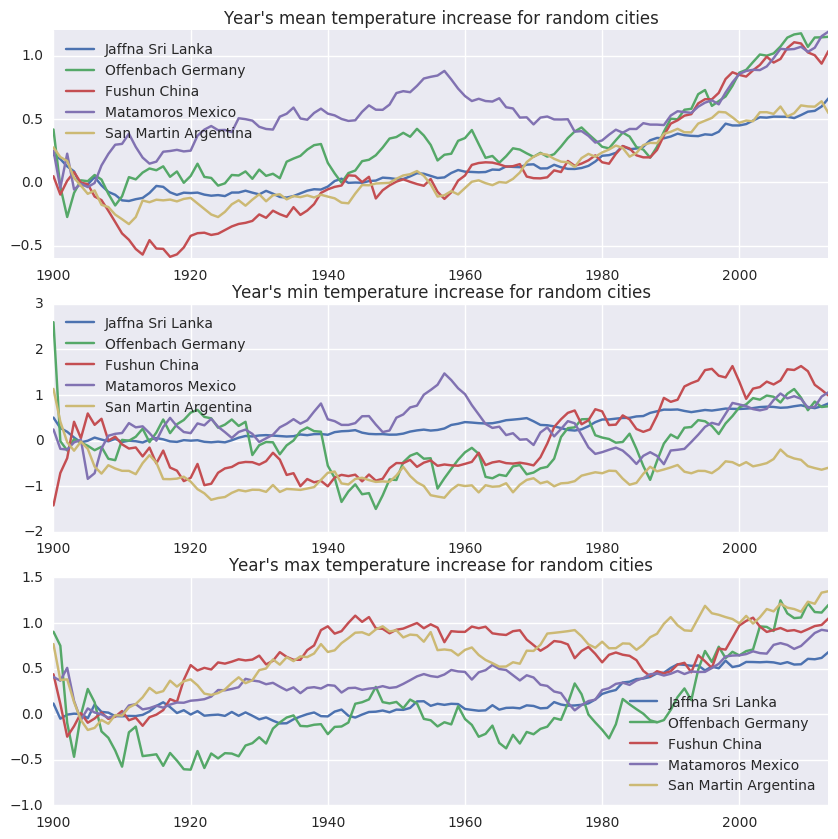

In [6]:
first_years_mean = city_means.iloc[:, :5].mean(axis=1) # mean temperature for the first 5 years
city_means_shifted = city_means.subtract(first_years_mean, axis=0)

def plot_temps(cities, city_ser, ax):
    first_years_mean = city_ser.iloc[:, :5].mean(axis=1)
    city_ser = city_ser.subtract(first_years_mean, axis=0)
    for city in random_cities:
        row = city_ser.loc[city]
        pd.stats.moments.ewma(row, 10).plot(label=row.name, ax=ax)
    ax.set_xlabel('')
    ax.legend(loc='best')

fig, axes = plt.subplots(3,1, figsize=(10,10))

n = 5
random_cities = city_means_shifted.sample(n).index

plot_temps(random_cities, city_means, axes[0])
plot_temps(random_cities, city_mins, axes[1])
plot_temps(random_cities, city_maxs, axes[2])

axes[0].set_title("Year's mean temperature increase for random cities")
axes[1].set_title("Year's min temperature increase for random cities")
axes[2].set_title("Year's max temperature increase for random cities")

### Year's mean temperatures tend to grow over the years but we can't say for sure that it applies to max and min temperatures

# GLOBAL WARMING animation

here is my effort to use matplotlib power to create an animated plot that proves that global warming israel.

In [7]:
cities_info = bycities.groupby(['City']).first()
cities_info.head()

dt  AverageTemperature  AverageTemperatureUncertainty  \
City                                                                            
A Coruña Spain  1900-01-01               8.089                          0.655   
Aachen Germany  1900-01-01               2.079                          0.545   
Aalborg Denmark 1900-01-01              -0.989                          0.588   
Aba Nigeria     1900-01-01              25.722                          0.892   
Abadan Iran     1900-01-01              11.636                          1.253   

                 Country Latitude Longitude  
City                                         
A Coruña Spain     Spain   42.59N     8.73W  
Aachen Germany   Germany   50.63N     6.34E  
Aalborg Denmark  Denmark   57.05N    10.33E  
Aba Nigeria      Nigeria    5.63N     8.07E  
Abadan Iran         Iran   29.74N    48.00E

### How to understand markers:
marker color shows if this year temperature is close to a record one for the city (dark blue for coldest temperatures, dark red for highest temperatures)  
marker size represents absolute difference between city median temperature and current year temperature

In [8]:
def get_temp_markers(city_names, year):
    points = np.zeros(len(city_names), dtype=[('lon', float, 1),
                                      ('lat', float, 1),
                                      ('size',     float, 1),
                                      ('color',    float, 1)])
    cmap = plt.get_cmap('coolwarm')
    
    for i, city in enumerate(city_names):
        city_temps = city_means.loc[city]
        _MIN, _MAX, _MEDIAN = city_temps.min(), city_temps.max(), city_temps.median()
        temp = city_temps.loc[year]
        
        coords = cities_info.loc[city][['Latitude', 'Longitude']].values
        lat = float(coords[0][:-1]) * (-1 if coords[0][-1] == 'S' else 1)
        lon = float(coords[1][:-1]) * (-1 if coords[1][-1] == 'W' else 1)
        
        points['lat'][i] = lat
        points['lon'][i] = lon
        points['size'][i] = 100 * abs(temp - _MEDIAN)
        points['color'][i] = (temp - _MIN) / (_MAX - _MIN)
            
    return points   

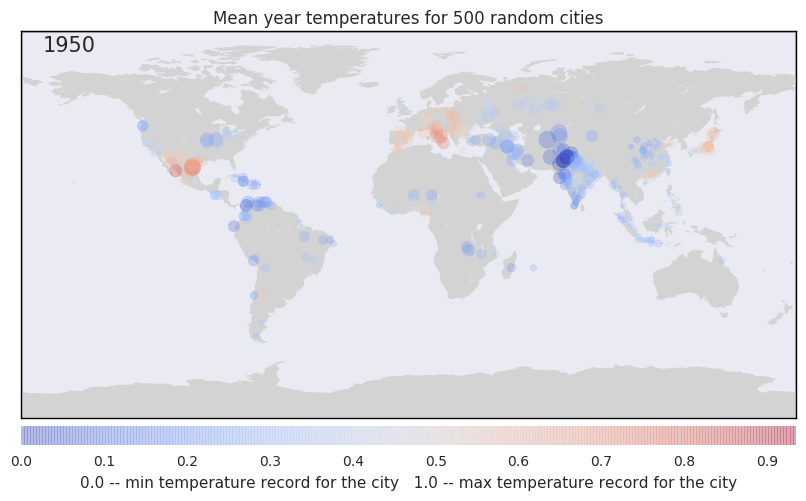

In [9]:
fig = plt.figure(figsize=(10, 10))
cmap = plt.get_cmap('coolwarm')

map = Basemap(projection='cyl')
map.drawmapboundary()
map.fillcontinents(color='lightgray', zorder=1)

START_YEAR = 1950
LAST_YEAR = 2013

n_cities = 500
random_cities = city_means.sample(n_cities).index
year_text = plt.text(-170, 80, str(START_YEAR),fontsize=15)

temp_markers = get_temp_markers(random_cities, START_YEAR)
xs, ys = map(temp_markers['lon'], temp_markers['lat'])
scat = map.scatter(xs, ys, s=temp_markers['size'], c=temp_markers['color'], cmap=cmap, marker='o', 
                   alpha=0.3, zorder=10)

def update(frame_number):
    current_year = START_YEAR + (frame_number % (LAST_YEAR - START_YEAR + 1))
    
    temp_markers = get_temp_markers(random_cities, current_year)
    xs, ys = map(temp_markers['lon'], temp_markers['lat'])

    scat.set_offsets(np.dstack((xs, ys)))
    scat.set_color(cmap(temp_markers['color']))
    scat.set_sizes(temp_markers['size'])
    
    year_text.set_text(str(current_year))

# # # Construct the animation, using the update function as the animation
# # # director.
ani = animation.FuncAnimation(fig, update, interval=500, frames=LAST_YEAR - START_YEAR + 1)

cbar = map.colorbar(scat, location='bottom')
cbar.set_label('0.0 -- min temperature record for the city   1.0 -- max temperature record for the city')
plt.title('Mean year temperatures for {} random cities'.format(n_cities))
plt.show()

I made a html5 video of this animation but couldn't display it on Kaggle kernels :( I was struggling for 2 hours and eventually managed to display a .gif file.

In [10]:
ani.save('animation.gif', writer='imagemagick', fps=2)


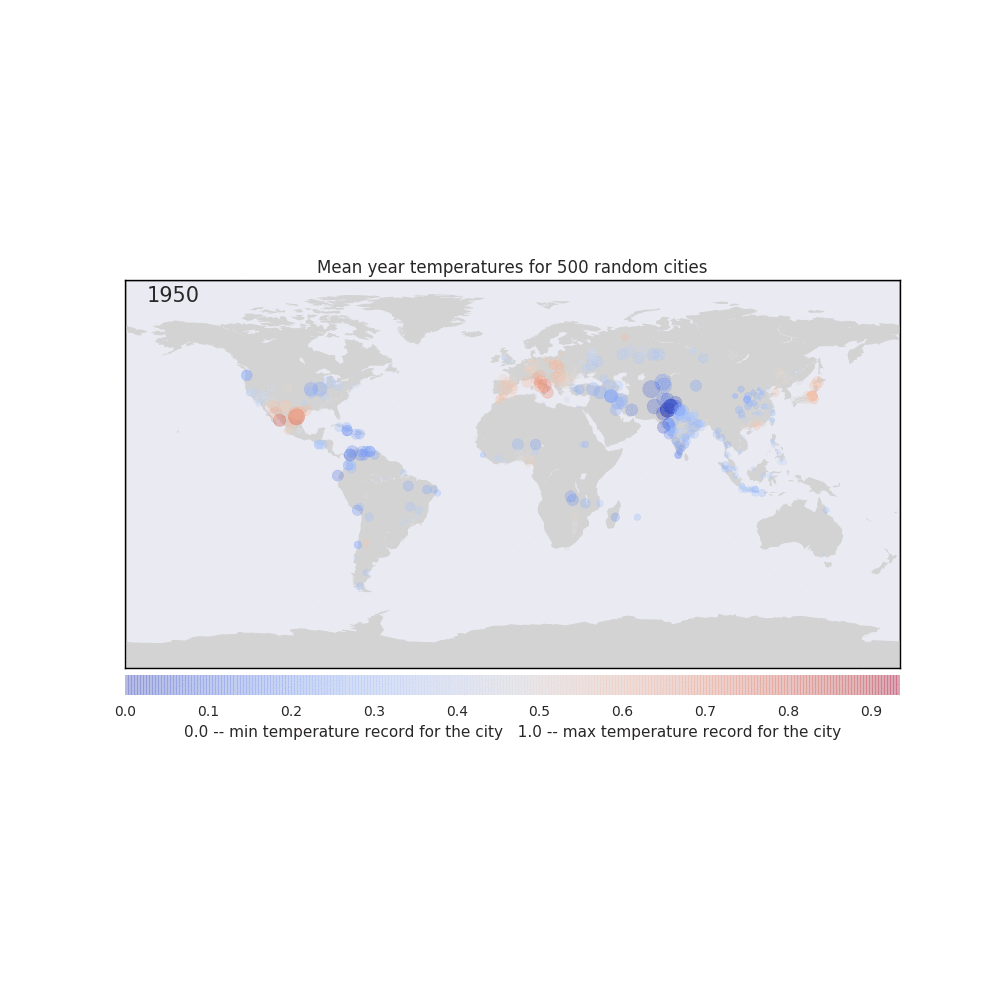

In [11]:
import io
import base64

filename = 'animation.gif'

video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

### GIF shows that the redness of the picture increases as the planet is slowly warming. 2013 year turns to be bright red, that means there were a lot of high temperature records. Global warming confirmed.